# Quantum Simulation of Hamiltonians using Product Formulas

Please execute the cell below before proceeding:

In [2]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy import linalg as sla
import itertools as iter
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper, LogarithmicMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, Operator, Pauli, SparsePauliOp, commutator
from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem, RealTimeEvolver, RealEvolver, SciPyRealEvolver, VarQRTE, NumPyEigensolver
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter, ParameterVector
from qiskit.synthesis import SuzukiTrotter, LieTrotter, MatrixExponential


## Contents:

1. [Introduction](#introduction)
2. [Theory](#theory-of-product-formulas)
2. [Electronic Hamiltonian](#electronic-hamiltonian)
3. [Heisen]


## Introduction

Quantum simulation is a method for understanding the attributes of physical systems over defined intervals of time. Such a technique can be used to emulate the time evolution of a physical system’s Hamiltonian operator given an initial state of the system. 
    
However, the accuracy of simulation is dependent upon the algorithm employed: the quantum circuit constructed to simulate a system can offer both benefits and deficits regarding query complexity, circuit depth, success rate, and error. [1] These four characteristics will be explored via the use of product formulas, which are algorithms that comprise Lie-Trotter-Suzuki decomposition methods. Although product formulas now compete with more recent algorithms, such as qubitization [12, 13] and quantum walks [14, 15, 16], these formulas are still a favorable place to begin exploring quantum simulation algorithms applied to quantum dynamics due to their relatively simple structure, lack of ancilla qubits, and high success probability [9]. Product formulas also provide a good ideal evolution approximation at `low time intervals (e.g., t≪1) [3]. 

This tutorial will primarily focus on the circuit depth and error characteristics of first- and even higher-order product formulas at various evolution times. A comparison between a variational-based time evolution algorithm [7] and product formulas is included to better illustrate the computational benefits and deficits of both approaches. These comparisons will feature Electronic, Heisenberg, and Ising Hamiltonians. Prior to these topics, an explanation covering the structure and practical implementation of product formulas is necessary.

## Theory of Product Formulas

Product Formulas, within this notebook, will be presented in one of two forms: first order Lie-Trotter formulas [2] and higher-order Suzuki formulas [6]. These two forms realize a product formula for a Hamiltonian with structure:


<img src= "./External Images/Ham_Structure.png" 
     align ="center"
     width ="100" />

where Γ is equal to the total number of summands within the Hamiltonian operator, and H_γ denotes a γ-ordered summand within the Hamiltonian. In general, a pth-order product formula can be expressed as: 

<img src= "./External Images/General_PF.png" 
     align ="center"
     width ="500" />

where ⅇ^(-itH) is the unitary operator used in evolving an initial state, and O(t^(p+1) ) is the Trotter Error of the product formula [3]. Further information on this general format will follow.

The circuit implementations of these two algorithm formats incurs an associated error term that signals a deviation factor from the idealized time evolution of a system. This error term is defined as the Trotter Error of a product formula [8]. The Trotter Error of a system can be influenced by the gate complexity, number of qubits in the input register, and total time for which the system evolves.

Moreover, the structure of the error term is dependent upon the structure and order of the product formula in which it appears. These error terms will be further explored within the respective definitions of Lie-Trotter/Suzuki formulas and Qiskit demonstrations that follow.

First order Lie-Trotter product formulas possess the simplest decomposition structures [2] and have a Trotter error that scales relative to a truncation of the Taylor expansion of the unitary operator [11]. This culminates to a product formula structure:

<img src= "./External Images/Lie_Trotter_Structure.png" 
     align ="center"
     width ="300" />
<img src= "./External Images/Lie_Trotter_Structure_2.png" 
     align ="center"
     width ="300" />

where, O(t^2 ), is the associated Trotter Error of the system. This can be constructed from the general pth-order product formula by noting that the order, p, is equal to 1. Despite this simple structure, the Trotter Error neglects significant terms that are dropped when truncating the Taylor expansion, thus rendering Lie-Trotter structures convenient but inaccurate in analyzing Trotter Error [1]. 

Higher-order Suzuki product formulas use symmetric decomposition structures, termed integrators, to simulate the time evolution of a Hamiltonian [10]. The second-order Suzuki formula, along with its generalized higher-order variant and associated recursive formula, is:

<img src= "./External Images/Suzuki_Trotter_Structure.png" 
     align ="center"
     width ="500" />

where u_k=1\/(4-4^(1\/(2k-1) ) and k denotes the order of the product formula. The upper equation is the symmetric integrator second order product formula, while the lower equation is the recursive equation for calculating an arbitrary even-ordered product formula. Although higher-order Suzuki formulas have been proven to possess a tighter Trotter Error bound than first order Lie-Trotter formulas [17], this bound does not take advantage of the commutativity of the Hamiltonian summands.

This tutorial will employ the following product formula generalization and Trotter Error approximation scheme:

<img src= "./External Images/General_PF_w_Error.png" 
     align ="center"
     width ="500" />

where α ̃_comm ≔ ∑_(γ_1,γ_2,…,γ_(p+1)) ‖[H_(γ_(p+1) ),…[H_(γ_2 ),H_(γ_1 ) ]]‖  is the commutator pre-factor (i.e., summation of spectral norms of the nested summand commutator), ϒ is the number of stages in the formula, ν represents the ν-th stage, a_((ν,γ)) is an arbitrary non-zero, real coefficient, and π_(ν(γ)) is the permutation order of the product formula [3]. The latter two parameters do not have a significant bearing on the analysis of Trotter Error. Moreover, this product formula is accompanied by a term known as the Trotter Number. Its expression is:

<img src= "./External Images/Trotter_Number.png" 
     align ="center"
     width ="300" />

where ε is the target accuracy that we wish to simulate within a system [4]. The Trotter Number is a useful utility in that it allows us to repeat the product formula and manipulate the time step of the constructed trotterization. The variable ε will be set to a constant equal to 1.6*10^(-3)  a.u. throughout the tutorial.

Of note, the Trotter Error of this generalized product formula is due to the assumed anti-Hermitian nature of the Hamiltonian; anti-hermiticity appears within quantum chemistry applications, and this permits the Trotter Error to be simplified to the above form [6]. These items in tandem will allow us to produce a trotterization of a unitary operator, approximate the ideal evolution of a system, and analyze the entailing Trotter Error of the product formula.

## Electronic Hamiltonian

### Dihydrogen Molecule (Molecular Orbital Basis):

The Electronic Hamiltonian represents the internal energies of a molecule following the removal of kinetic energy terms from the Hamiltonian due to Born-Oppenheimer approximation [19]. This Hamiltonian has the nuclear coordinate form:

<img src= "./External Images/Electronic_Ham.png" 
     align ="center"
     width ="500" />

where r_i and r_j are the coordinates of the ith and jth electron, respectively, m_e is the mass of the electron, Z_I is the atomic number of the nucleus I, R_I are the coordinates of the nucleus I, and e is the electron charge [17]. This form will not be relevant to practical applications of product formulas. The second quantized form (Molecular Orbital basis) of the Electronic Hamiltonian is:

<img src= "./External Images/Electronic_Ham_2nd.png" 
     align ="center"
     width ="500" />

where 〖a ̂_k〗^† and a ̂_k are the creation and annihilation operators of the fermions, and h_pq and h_pqrs
are the 1-body and 2-body integrals, respectively. Further information regarding second quantized Electronic Hamiltonians can be found here: [18]. Using the Jordan-Wigner Transformation, we will bring this fermionic Electronic Hamiltonian into the qubit space to manipulate it.

We will begin learning how to implement both first- and higher-order product formulas using Electronic Hamiltonians via interactive examples. Be sure to read the comments in the code for more notes.


#### Via Trotterization Method:

/home/ssr/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


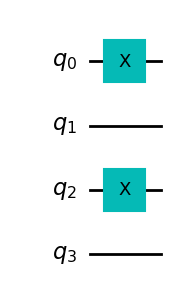

In [3]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()

# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals

# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op() # This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)

# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

HartreeFock_initial = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

# Draw the initial state to evolve:

HartreeFock_initial.draw('mpl')



In [103]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the Product Formula:

'''These are the general control parameters for the Electronic Hamiltonian. Refer to these (and change) these variables to experiment with various product formulas'''

PF_order = 2 # Order of Product Formula.
final_time = 100 # Termination time of real time evolution.
Trotter_Num = 50 # Trotter number associated with Product Formula construction.
time_step = 1 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
epsilon = 1.6 * 10**-3 # Select a desired chemical accuracy for simulation purposes.

evo_time_range = np.arange(0, final_time, time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.


In [104]:
# Define a first order Product Formula generation function:

def First_Order(hamiltonian, initial_state, trot_num, time, step): 

    # Partition each qubit_h2_Ham list object into separate list of exponentiated summands:

    exp_summand = list()
    evo_time = Parameter('t')
    estimator = Estimator()
    energies = list()
    coefficients_a_re = list()
    coefficients_b_re = list()
    coefficients_a_im = list()
    coefficients_b_im = list()

    for i in range(0, len(hamiltonian)):
        exp_summand.append(PauliEvolutionGate(hamiltonian[i], time=evo_time))

    # Append PauliEvolutionGates to template circuit, emulating a first order trotterization scheme:

    PF_circuit = QuantumCircuit(initial_state.width()) # Create the templated product formula QuantumCircuit object.

    for i in range(len(exp_summand)):
        PF_circuit.append(exp_summand[i], range(initial_state.width()))

    composed_circ = initial_state # Update the Circuit.

    # Append the initial state and subsequently aggregated circuit to however many repetitions of the PF_circuit are desired:

    for i in range(trot_num):
        composed_circ = composed_circ.compose(PF_circuit, range(initial_state.width()))

    # Calculate the expectation value along evo_time_range array:
    
    for k in range(len(evo_time_range)):
        result = estimator.run(composed_circ, hamiltonian, parameter_values=(evo_time_range[k]/trot_num)).result() 
        energies.append(np.real(result.values)) # Cache the result.

    # Convert the initial HartreeFock state to an instruction

    initial_instruction = initial_state.to_instruction() 
    
    initial_vector = Statevector.from_instruction(initial_instruction) 

    Lie = LieTrotter(trot_num, False, "chain")

    for k in range(len(evo_time_range)):

        exact_unitary_Exp = PauliEvolutionGate(hamiltonian, time=evo_time_range[k], synthesis= Lie)

        template_Exp = QuantumCircuit(4)

        template_Exp.compose(exact_unitary_Exp, range(4))

        evo_op_Exp = Operator.from_circuit(template_Exp)

        evolved_state_Exp = initial_vector.evolve(exact_unitary_Exp)

        coefficients_a_re.append(np.real(evolved_state_Exp.data[5]))
        coefficients_a_im.append(np.imag(evolved_state_Exp.data[5]))
        coefficients_b_re.append(np.real(evolved_state_Exp.data[10]))
        coefficients_b_im.append(np.imag(evolved_state_Exp.data[10]))

    real_pairs = (coefficients_a_re, coefficients_b_re) # Real components of the coefficients.
    imag_pairs = (coefficients_a_im, coefficients_b_im) # Imaginary components of the coefficients.

    coefficient_pairs = (real_pairs, imag_pairs)

    Lie_tuple = (composed_circ, energies, coefficient_pairs) # Construct a tuple of the composed circuit, associated evolution energies, and evolved state coefficients.

    return (Lie_tuple) # Return the composed first order Product Formula circuit.
    

In [105]:
# Define a 2k-order Product Formula generation function (in addition to obtaining the expectation value):

def  Suzuki(hamiltonian, initial_state, order, trot_num, time, time_step):

    Suzuki_energies = list()
    estimator = Estimator()
    coefficients_a_re = list()
    coefficients_b_re = list()
    coefficients_a_im = list()
    coefficients_b_im = list()

    # Produce example circuit via Suzuki Trotterization method: 
   
    Suzuki_circ = HartreeFock_initial.compose(SuzukiTrotter(order, trot_num, insert_barriers=True).synthesize(PauliEvolutionGate(hamiltonian, time=Parameter('t'))))

    # Calculate actual expectation values for circuit/real time evolution over described time interval:

    for k in range(len(evo_time_range)):

        evo_prob = TimeEvolutionProblem(hamiltonian, evo_time_range[k], initial_state) # Generate the initial Time Evolution problem.

        Suzuki = SuzukiTrotter(order, trot_num, True, "chain", None) # Invoke the Suzuki-Trotter formula.

        trotter_qrte = TrotterQRTE(product_formula=Suzuki, estimator=estimator, num_timesteps=trot_num) # Invoke the Trotter Real Time Evolution Algorithm object.

        evolved_state = trotter_qrte.evolve(evo_prob).evolved_state

        result = estimator.run(evolved_state, hamiltonian, None).result()

        Suzuki_energies.append(np.real(result.values))

        evolved_instruction = evolved_state.to_instruction()

        evolved_vector = Statevector.from_instruction(evolved_instruction)

        coefficients_a_re.append(np.real(evolved_vector.data[5]))
        coefficients_a_im.append(np.imag(evolved_vector.data[5]))
        coefficients_b_re.append(np.real(evolved_vector.data[10]))
        coefficients_b_im.append(np.imag(evolved_vector.data[10]))

    real_pairs = (coefficients_a_re, coefficients_b_re)
    imag_pairs = (coefficients_a_im, coefficients_b_im)

    coefficient_pairs = (real_pairs, imag_pairs)

    Suzuki_tuple = (Suzuki_circ, Suzuki_energies, coefficient_pairs)

    return (Suzuki_tuple) 

In [106]:
# Define general Product Formula creation function:

def product_formula(hamiltonian, initial_state, order, trot_num, time, time_step):

    # hamiltonian = PauliOp or SparsePauliOp Hamiltonian to be Trotterized.
    # initial_state = Initial QuantumCircuit configuration from which the system will be evolved. 
    # order = Order of the desired Product Formula.
    # trot_num = Desired Trotter Number for the Product Formula.
    # time = Time to which the Product Formula will evolve.
    # time_step = Increments at which the system will evolve. 

    if (order < 1):
        return ("Invalid Order Chosen. Choose an integer from [1, inf].") 
    elif (order == 1):
        return First_Order(hamiltonian, initial_state, trot_num, time, time_step)
    elif (order >= 2):
        return Suzuki(hamiltonian, initial_state, order, trot_num, time, time_step)
    else:
        return ("Invalid Order Chosen. Use integers!")

In [107]:
# Define an alpha_comm calculation method: 

def a_comm(hamiltonian, order):

    perm_list = list()
    alpha_comm = 0

    perm_list = list(iter.combinations_with_replacement(hamiltonian, order + 1))

    for j in range(len(perm_list)):

        j_list = list(perm_list[j])

        for i in range(len(perm_list[j]) - 1, 0, -1):

            comm = commutator(j_list[i - 1], j_list[i])
            j_list[i - 1] = comm
            #print(comm)

        op = j_list[0]
        op_adjoint = op.adjoint()

        self_matrix = op_adjoint.compose(op)

        eigenvals = la.eig(self_matrix.to_matrix())[0]

        alpha_comm += np.sqrt(max(eigenvals)) # Compute the spectral norm and append to comm list

    return alpha_comm

In [108]:
# Obtain the desired Product Formula circuit and draw it:
'''Warning: Circuits grow exponentially in gate complexity (i.e, size) relative to order! Be careful when drawing higher-order circuits!'''

PF_circ = product_formula(qubit_h2_Ham, HartreeFock_initial, PF_order, Trotter_Num, final_time, time_step) # Generate the circuit.

#PF_circ[0].draw('mpl', filename='./Circuit Drawings/PF_Circuit_' + str(PF_order) + 'o_' + str(Trotter_Num) + 'r_h2') # Draw the resulting circuit.

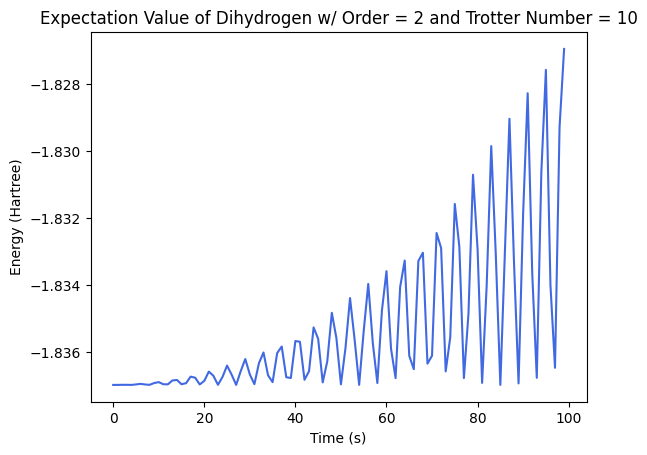

In [ ]:
# Graph the energy variation over the specified time interval (in the case of a Suzuki-Trotter circuit):

plt.plot(evo_time_range, PF_circ[1], color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Dihydrogen w/ Order = " + str(PF_order) + " and Trotter Number = " + str(Trotter_Num))
plt.savefig('./Plots/Product Formulas/Expectation Values/h2_' + str(PF_order) + 'o_' + str(evo_time_range[-1]) + 's_' + str(Trotter_Num) + 'r.png')

The above figure showcases the expectation value of Dihydrogen Hamiltonian within the evolved system.

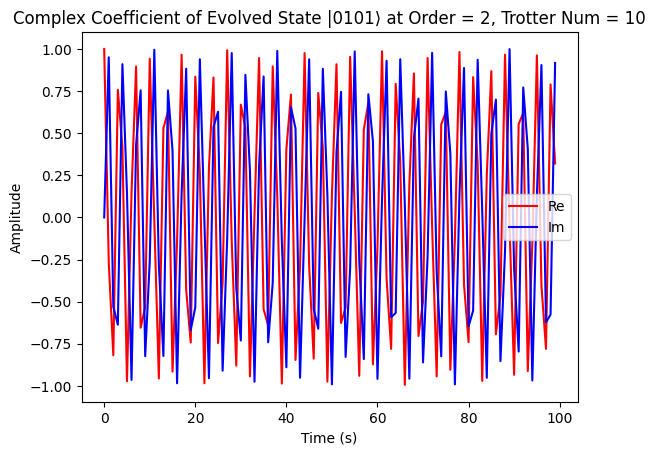

In [ ]:
# Plot the evolved state coefficients:

#fig, (ax1, ax2) = plt.subplots(2)
#fig.suptitle('Real and Imaginary Coefficients of Evolved State')
plt.plot(evo_time_range, PF_circ[2][0][0], color = 'r', label = "Re")
plt.plot(evo_time_range, PF_circ[2][1][0], color = 'b', label = "Im")
plt.title('Complex Coefficient of Evolved State |0101⟩ at Order = ' + str(PF_order) + ', Trotter Num = ' + str(Trotter_Num))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.savefig('./Plots/Product Formulas/States/Coefficient_h2_0101_' + str(PF_order) + 'o_' + str(Trotter_Num) + 'r.png' )


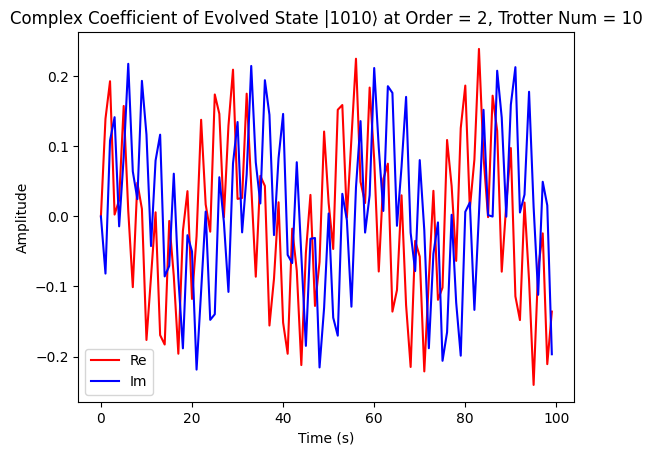

In [ ]:
plt.plot(evo_time_range, PF_circ[2][0][1], color = 'r', label = "Re")
plt.plot(evo_time_range, PF_circ[2][1][1], color = 'b', label = "Im")
plt.title('Complex Coefficient of Evolved State |1010⟩ at Order = ' + str(PF_order) + ', Trotter Num = ' + str(Trotter_Num))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.savefig('./Plots/Product Formulas/States/Coefficient_h2_1010_' + str(PF_order) + 'o_' + str(Trotter_Num) + 'r.png' )


#### Trotter Error Bound:

In [ ]:
# Calculate the expected Trotter Error for Electronic structure Hamiltonian:

#alpha_comm = (qubit_h2_Ham.num_qubits)**(PF_order + 1) # Formal definition of this coefficient is found here: [20]
alpha_comm_h2 = a_comm(qubit_h2_Ham, PF_order)

h2_error = np.real(alpha_comm_h2 * evo_time_range[-1]**(PF_order + 1)) # Based on [4] commutator-scaled Trotter error.

print("The expected error term of the Product Formula algorithm, with commutator scaling, is: O(" + str(h2_error) + ")")


The expected error term of the Product Formula algorithm, with commutator scaling, is: O(279010.0392325651)


#### Required Trotter Number:

This widget is employed to calculate the necessary Trotter Number to achieve near-ideal evolution.

In [ ]:
# Calculate necessary Trotter_Num to achieve chemical accuracy constant:

trotter_num_need = (((qubit_h2_Ham.num_qubits * evo_time_range[-1])**(1+1/PF_order)) / epsilon**(1/PF_order))

print("The required Trotter Number to achieve the desired chemical accuracy is: " + str(int(trotter_num_need)))

The required Trotter Number to achieve the desired chemical accuracy is: 197007


#### Gate Complexity Bound:

This widget is employed to calculate the gate complexity of the generated Product Formula:

In [ ]:
# Plot the relationship between Product Formula Order and Gate Complexity:

gate_complexity = (len(qubit_h2_Ham) * alpha_comm_h2**(1/PF_order) * evo_time_range[-1]**(1+1/PF_order))

print("The number of gate required to achieve constant accuracy is: O(" + str(int(np.real(gate_complexity))) + ").")

The number of gate required to achieve constant accuracy is: O(7923).


#### Relationship Plots:

Text(0.5, 1.0, 'Required Trotter Number Relative to Order to Achieve Desired Accuracy')

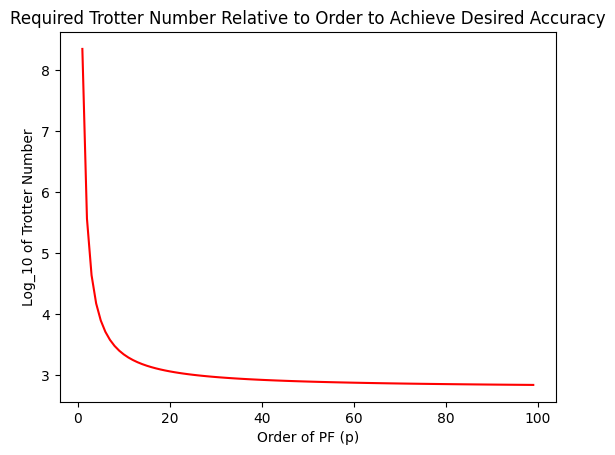

In [ ]:
# Plot the relationship between Trotter Number and Product Formula Order:

Order_range = np.arange(1, 100, 1) # Range to plot Product Formula order
Trotter_num_range = list() # List for Trotter Number required per order and qubits.

for j in range(len(Order_range)):
    Trotter_num_range.append(np.log10(((qubit_h2_Ham.num_qubits * evo_time_range[-1])**(1+1/Order_range[j])) / epsilon**(1/Order_range[j])))

plt.plot(Order_range, Trotter_num_range, color="red")
plt.xlabel("Order of PF (p)")
plt.ylabel("Log_10 of Trotter Number")
plt.title("Required Trotter Number Relative to Order to Achieve Desired Accuracy")


As demonstrated within the above figure, the Trotter Number required to achieve accuracy within an evolution exponentially decreases with higher-order product formulas.

/home/ssr/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Required Gate Number Relative to Order to Achieve Desired Accuracy')

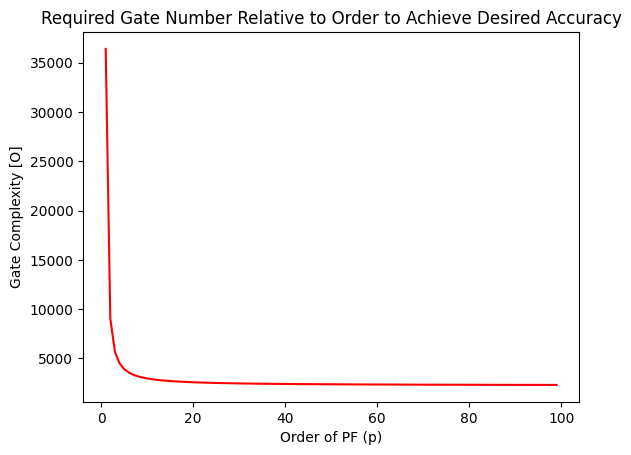

In [ ]:
# Plot the relationship between Product Formula Order and Gate Complexity:

gate_compl = list()
Order_range = np.arange(1, 100, 1)

for j in range(len(Order_range)):
    gate_compl.append(len(qubit_h2_Ham) * alpha_comm_h2**(1/Order_range[j]) * evo_time_range[-1]**(1+1/Order_range[j]))

plt.plot(Order_range, gate_compl, color="red")
plt.xlabel("Order of PF (p)")
plt.ylabel("Gate Complexity [O]")
plt.title("Required Gate Number Relative to Order to Achieve Desired Accuracy")

#### Via Standard Tools:

In [1]:
# Generate the evolved state vectors and cache their associated coefficients:

coefficients_a_re = list()
coefficients_b_re = list()
coefficients_a_im = list()
coefficients_b_im = list()

exact_energies = list()

exact_initial = HartreeFock_initial.to_instruction()

exact_initial = Statevector.from_instruction(exact_initial)

m_exp = MatrixExponential()
#Lie = LieTrotter(1, False, "chain")

for k in range(len(evo_time_range)):

    exact_unitary_Exp = PauliEvolutionGate(qubit_h2_Ham, time=evo_time_range[k], synthesis= m_exp)

    template_Exp = QuantumCircuit(4)

    template_Exp.compose(exact_unitary_Exp, range(4))

    evo_op_Exp = Operator.from_circuit(template_Exp)

    evolved_state_Exp = exact_initial.evolve(exact_unitary_Exp)

    exact_energies.append(evolved_state_Exp.expectation_value(qubit_h2_Ham))

    coefficients_a_re.append(np.real(evolved_state_Exp.data[5]))
    coefficients_a_im.append(np.imag(evolved_state_Exp.data[5]))
    coefficients_b_re.append(np.real(evolved_state_Exp.data[10]))
    coefficients_b_im.append(np.imag(evolved_state_Exp.data[10]))

real_pair = (coefficients_a_re, coefficients_b_re)
imag_pair = (coefficients_a_im, coefficients_b_im)

NameError: name 'HartreeFock_initial' is not defined

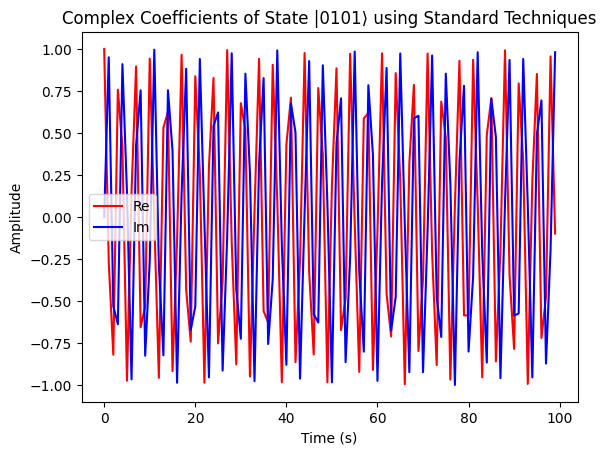

In [ ]:
# Plot the Real and Imaginary components of the two resultant states in the evolved statevector:

plt.plot(evo_time_range, real_pair[0], color='r', label= "Re")
plt.plot(evo_time_range, imag_pair[0], color='b', label= "Im")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.title("Complex Coefficients of State |0101⟩ using Standard Techniques")
plt.savefig("./Plots/Product Formulas/States/Complex_Coefficients_of_State_0101_Standard_" + str(final_time) + "s_h2.png")

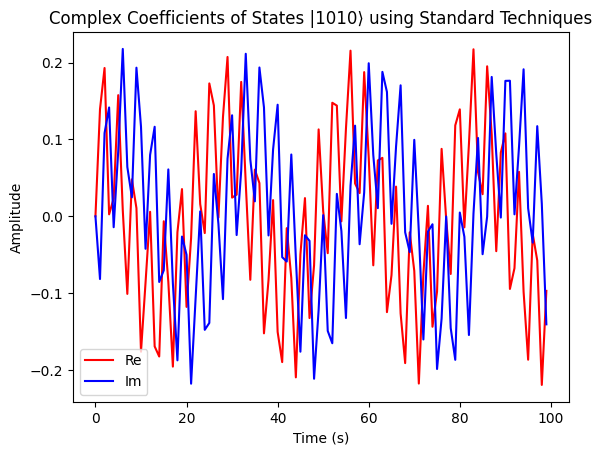

In [ ]:
# Plot the Real and Imaginary components of the two resultant states in the evolved statevector:

plt.plot(evo_time_range, real_pair[1], color='red', label="Re")
plt.plot(evo_time_range, imag_pair[1], color='blue', label="Im")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.title("Complex Coefficients of States |1010⟩ using Standard Techniques")
plt.savefig("./Plots/Product Formulas/States/Complex_Coefficients_of_State_1010_Standard_" + str(final_time) + "s_h2.png")

/home/ssr/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


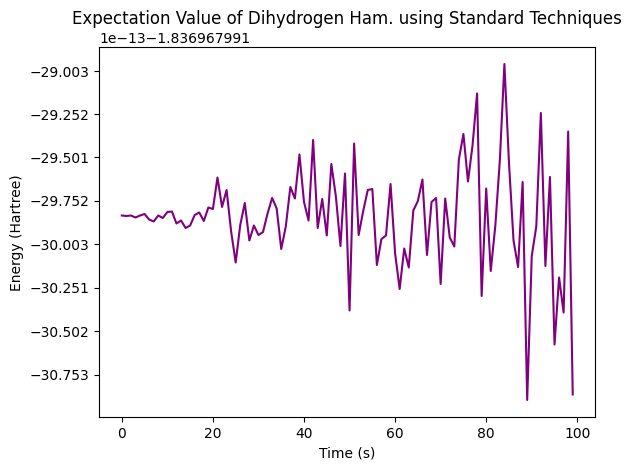

In [ ]:
plt.plot(evo_time_range, exact_energies, color='purple')
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Dihydrogen Ham. using Standard Techniques")
plt.savefig("./Plots/Product Formulas/Expectation Values/Expectation_Value_Standard_h2.png")

#### Comparision between Ideal and Analytical:

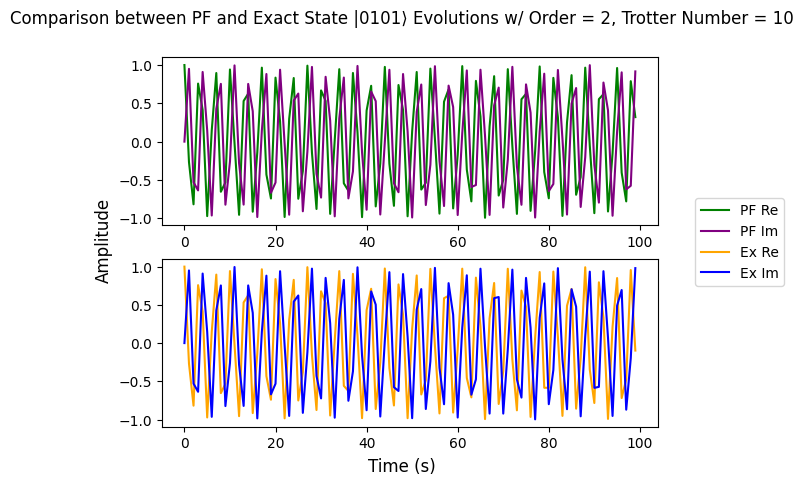

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle("Comparison between PF and Exact State |0101⟩ Evolutions w/ Order = " + str(PF_order) + ", Trotter Number = " + str(Trotter_Num))
axs[0].plot(evo_time_range, PF_circ[2][0][0], color = 'g', label = "PF Re")
axs[0].plot(evo_time_range, PF_circ[2][1][0], color = 'purple', label = "PF Im")
axs[1].plot(evo_time_range, real_pair[0], color='orange', label= "Ex Re")
axs[1].plot(evo_time_range, imag_pair[0], color='b', label= "Ex Im")
fig.supxlabel("Time (s)")
fig.supylabel("Amplitude")
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lin, []) for lin in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.865,0.41))
plt.savefig("./Plots/Product Formulas/States/Coefficient_Comparison_of_State_0101_" + str(final_time) + "s_" + str(PF_order) + "o_" + str(Trotter_Num) + "r_h2.png")

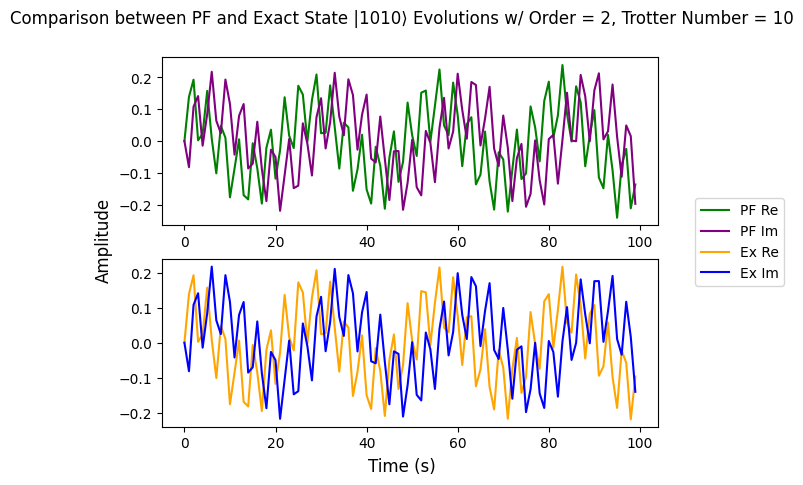

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle("Comparison between PF and Exact State |1010⟩ Evolutions w/ Order = " + str(PF_order) + ", Trotter Number = " + str(Trotter_Num))
axs[0].plot(evo_time_range, PF_circ[2][0][1], color = 'g', label = "PF Re")
axs[0].plot(evo_time_range, PF_circ[2][1][1], color = 'purple', label = "PF Im")
axs[1].plot(evo_time_range, real_pair[1], color='orange', label= "Ex Re")
axs[1].plot(evo_time_range, imag_pair[1], color='b', label= "Ex Im")
fig.supxlabel("Time (s)")
fig.supylabel("Amplitude")
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lin, []) for lin in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.865,0.41))
plt.savefig("./Plots/Product Formulas/States/Coefficient_Comparison_of_State_1010_" + str(final_time) + "s_" + str(PF_order) + "o_" + str(Trotter_Num) + "r_h2.png")

In [101]:
# Print the associated error between these two curves: 

print("The expected error term of the Product Formula algorithm, with commutator scaling, is: O(" + str(h2_error) + ")")

The expected error term of the Product Formula algorithm, with commutator scaling, is: O(279010.0392325651)


#### Lattice-based Hamiltonians:

In [208]:
from math import pi
from qiskit_nature.second_q.hamiltonians.lattices import(
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel, HeisenbergModel, IsingModel
from qiskit_nature.second_q.mappers import LinearMapper
from qiskit.circuit.library import EfficientSU2

Heisenberg Model (Lattice-based):

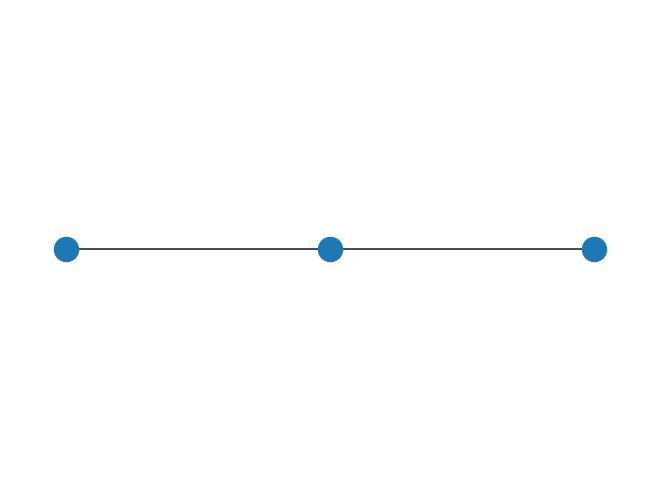

In [209]:
# Instantiate Line_Lattice for Hamiltonian generation:

line_lattice = LineLattice(num_nodes=3, boundary_condition=BoundaryCondition.OPEN)
heisenberg_model = HeisenbergModel(line_lattice, (1.0, 1.0, 1.0), (0.0, 0.0, 1.0))
line_lattice.draw()

In [ ]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the Product Formula:

'''These are the general control parameters for the Electronic Hamiltonian. Refer to these (and change) these variables to experiment with various product formulas'''

hb_PF_order = 2 # Order of Product Formula.
hb_final_time = 100 # Termination time of real time evolution.
hb_Trotter_Num = 10 # Trotter number associated with Product Formula construction.
hb_time_step = 1 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
hb_epsilon = 1.6 * 10**-3 # Select a desired chemical accuracy for simulation purposes.

hb_evo_time_range = np.arange(0, final_time, time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.


In [210]:
# Obtain Second Quantized operator of Heisenberg Model Hamiltonian:

hb_Ham = heisenberg_model.second_q_op()

# Invoke Linear Mapper/Transformation to bring Hamiltonian into Qubit Space:

log_map = LogarithmicMapper()

qubit_hb_Ham = log_map.map(hb_Ham.simplify())

print(qubit_hb_Ham)
#print(qubit_hb_Ham.num_qubits)
#print(hb_Ham)

0.25 * IXX
+ 0.25 * IYY
+ 0.25 * IZZ
+ 0.25 * XXI
+ 0.25 * YYI
+ 0.25 * ZZI
+ 0.5 * IIZ
+ 0.5 * IZI
+ 0.5 * ZII


In [211]:
# Construct appropriate ansatz for Variational Time Evolution:

hb_initial_state = QuantumCircuit(qubit_hb_Ham.num_qubits)
hb_initial_state.x(range(0, qubit_hb_Ham.num_qubits, 2))

#hb_initial_state.draw('mpl') # Known as the Néel state of a Lattice-based Hamiltonian

In [212]:
# Generate an appropriate first order trotterization scheme for Heisenberg Model:

hb_exp_summand = list()
hb_evo_time = Parameter('t')

for i in range(0, len(qubit_hb_Ham)):
    hb_exp_summand.append(PauliEvolutionGate(qubit_hb_Ham[i], time=hb_evo_time))

# Append PauliEvolutionGates to template circuit, emulating a first order trotterization scheme:

hb_PF_circuit = QuantumCircuit(hb_exp_summand[0].num_qubits)

for i in range(len(hb_exp_summand)):
    hb_PF_circuit.append(hb_exp_summand[i], range(hb_exp_summand[i].num_qubits))

# Append Product Formula to initial state circuit, initiating a first order trotterization scheme:

hb_composed_circ = hb_initial_state

for i in range(hb_Trotter_Num):
    hb_composed_circ = hb_composed_circ.compose(hb_PF_circuit, range(hb_initial_state.width()))

In [ ]:
# Prepare an estimator to measure expectation value of Hamiltonian:

hb_energies = list()
estimator = Estimator()

for k in range(len(hb_evo_time_range)):
    hb_result = estimator.run(hb_composed_circ, qubit_hb_Ham, parameter_values=(hb_evo_time_range[k]/hb_Trotter_Num)).result()
    hb_energies.append(np.real(hb_result.values))

In [ ]:
hb_PF_circ = PF

Text(0.5, 1.0, 'Expectation Value of Heisenberg Hamiltonian over Trotterization Evolution')

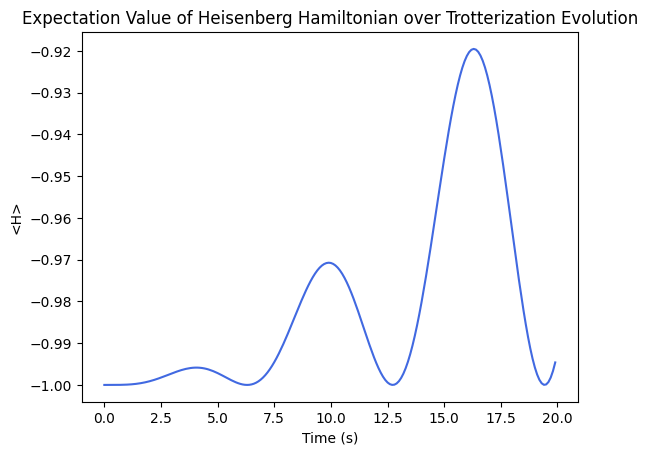

In [64]:
# Graph the energy variation over the specified time interval:

plt.plot(hb_evo_time_range, hb_energies, color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("<H>")
plt.title("Expectation Value of Heisenberg Hamiltonian over Trotterization Evolution")

In [821]:
# Calculate the expected and actual error:

hb_error = (len(hb_exp_summand)**2 * hb_evo_time_range[-1]**2) / hb_Trotter_Num

print("The expected error term of the Lie-Trotter-style algorithm is: O(" + str(hb_error) + ")")

The expected error term of the Lie-Trotter-style algorithm is: O(117612.0)


Ising Model (Lattice-based):

In [ ]:
# Instantiate Line_Lattice for Hamiltonian generation:

line_lattice = LineLattice(num_nodes=3, boundary_condition=BoundaryCondition.OPEN)
ising_model = IsingModel(
    line_lattice.uniform_parameters(
        uniform_interaction = -1.0,
        uniform_onsite_potential = 0.0,
    ),
)

In [ ]:
# Obtain Second Quantized operator of Ising Model Hamiltonian:

i_Ham = ising_model.second_q_op()

# Invoke Linear Mapper/Transformation to bring Hamiltonian into Qubit Space:

log_map = LogarithmicMapper()

qubit_i_Ham = log_map.map(i_Ham.simplify())

print(qubit_i_Ham)
#print(qubit_hb_Ham.num_qubits)

-0.25 * IZZ
- 0.25 * ZZI


In [ ]:
# Construct appropriate ansatz for Real Time Evolution:

i_initial_state = QuantumCircuit(qubit_i_Ham.num_qubits)
i_initial_state.x(range(0, qubit_i_Ham.num_qubits, 2))

#hb_initial_state.draw('mpl') # Known as the Néel state of a Lattice-based Hamiltonian

In [ ]:
# Generate an appropriate first order trotterization scheme for Ising Model:

i_exp_summand = list()
i_evo_time_range = np.arange(0, 20, 0.1)
i_evo_time = Parameter('t')

for i in range(0, len(qubit_i_Ham)):
    i_exp_summand.append(PauliEvolutionGate(qubit_i_Ham[i], time=i_evo_time))

NameError: name 'qubit_i_Ham' is not defined

In [ ]:
# Append PauliEvolutionGates to template circuit, emulating a first order trotterization scheme:

i_PF_circuit = QuantumCircuit(i_exp_summand[0].num_qubits)

for i in range(len(i_exp_summand)):
    i_PF_circuit.append(i_exp_summand[i], range(i_exp_summand[i].num_qubits))

#hb_PF_circuit.draw('mpl')

In [ ]:
# Append Product Formula to initial state circuit, initiating a first order trotterization scheme:

i_Trotter_Num = 20 # Num of Trotter_Num for approximation purposes

i_composed_circ = i_initial_state

for i in range(i_Trotter_Num):
    i_composed_circ = i_composed_circ.compose(i_PF_circuit, range(i_initial_state.width()))

#hb_composed_circ.draw('mpl')

In [ ]:
# Prepare an estimator to measure expectation value of Hamiltonian:

i_energies = list()
estimator = Estimator()

for k in range(len(i_evo_time_range)):
    i_result = estimator.run(i_composed_circ, qubit_i_Ham, parameter_values=(i_evo_time_range[k]/i_Trotter_Num)).result()
    i_energies.append(np.real(i_result.values))

Text(0.5, 1.0, 'Expectation Value of Ising Hamiltonian over Trotterization Evolution')

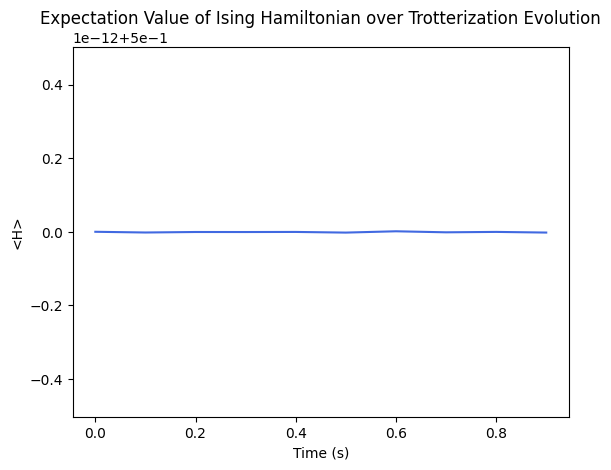

In [ ]:
# Graph the energy variation over the specified time interval:

plt.plot(i_evo_time_range, i_energies, color="royalblue")
plt.xlabel("Time (s)")
#plt.xlim(0, 1)
plt.ylabel("<H>")
plt.title("Expectation Value of Ising Hamiltonian over Trotterization Evolution")

In [920]:
# Calculate the expected and actual error:

i_error = (len(i_exp_summand)**2 * i_evo_time_range[-1]**2) / i_Trotter_Num

print("The expected error term of the Lie-Trotter-style algorithm is: O(" + str(i_error) + ")")

The expected error term of the Lie-Trotter-style algorithm is: O(254.97702400000003)


## Discussion



## Citations

1.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 4.
2.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021).12.
3.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 13.
4.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 22.
5.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 24.
6.	Wiebe, N., Dominic, B., Høyer, P., Sanders, B. C. Higher Order Decompositions of Ordered Operator Exponentials. J. Phys. A: Math. Theor. 43, 065203 (2010), 3.
7.	Qiskit – VarQRTE Documentation: https://qiskit.org/documentation/stubs/qiskit.algorithms.VarQRTE.html 
8.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 4-6.
9.	Childs, A. M., Maslov, D., Nam, Y., Ross, N. J., Su, Y. Toward the first quantum simulation with quantum speedup. Proceedings of the National Academy of Sciences 115, 9456-9461 (2018).
10.	Masuo Suzuki, General theory of fractal path integrals with applications to many-body theories and statistical physics, Journal of Mathematical Physics 32 (1991), no. 2, 400–407.
11.	Seth Lloyd, Universal quantum simulators, Science 273 (1996), no. 5278, 1073–1078
12.	Low, G. H. & Chuang, I. L. Hamiltonian simulation by qubitization. Quantum 3, 163 (2019).
13.	Berry, D. W., Gidney, C., Motta, M. McClean, J. R. & Babbush, R. Qubitization of arbitrary basis quantum chemistry leveraging sparsity and low rank factorization. Quantum 3, 208 (2019).
14.	Childs, A. M. Universal computation by quantum walk. Phys. Rev. Lett. 102, 180501 (2009).
15.	Childs, A. M. On the relationship between continuous- and discrete-time quantum walk. Commun. Math. Phys. 294, 581-603 (2009).
16.	Berry, D. W. & Childs, A. M. Black-box Hamiltonian simulation and unitary implementation. Quantum Inf. Comput. 12, 29-62 (2012). 
17.	Qiskit – Electronic Structure: https://qiskit.org/ecosystem/nature/tutorials/01_electronic_structure.html
18.	Quantum Condensed Matter Field Theory (Chapter 2) - University of Cambridge Lecture Notes: https://www.tcm.phy.cam.ac.uk/~bds10/tp3/secqu.pdf 
19.	Born-Oppenheimer Approximation – Northeastern University Lecture Notes: https://web.northeastern.edu/afeiguin/phys5870/phys5870/node9.html 
20.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 40.
21.	Qiskit – Transverse-field Ising Models: https://qiskit.org/ecosystem/nature/stubs/qiskit_nature.second_q.hamiltonians.IsingModel.html 
22.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 74-75.

